# Task 2

In this task, we aim to develop a neural network that can output a time prediction, based on an image of a clock.
This will be done using several different methods, ranging from pure classification to regression.

# Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# Load data

The data will be loaded from the google drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

images_path = '/content/drive/My Drive/images.npy'
labels_path = '/content/drive/My Drive/labels.npy'

images = np.load(images_path)
labels = np.load(labels_path)

# Normalize the pixel values
images = images.astype('float32') / 255.0

# Since the images are grayscale, we need to expand the dimensions so they can fit into a CNN
images = np.expand_dims(images, axis=-1)

print(f"Images shape: {images.shape}")
print(f"Images data type: {images.dtype}")
print(f"Labels shape: {labels.shape}")
print(f"Labels data type: {labels.dtype}")


ModuleNotFoundError: No module named 'google.colab'

# Inspect data

We will visualise some images to assure that the data is in the correct format, and see that the labels are uniformly distributed.

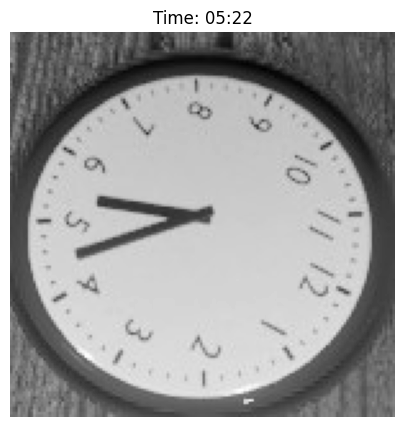

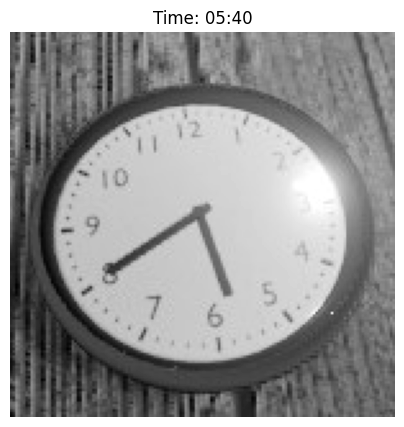

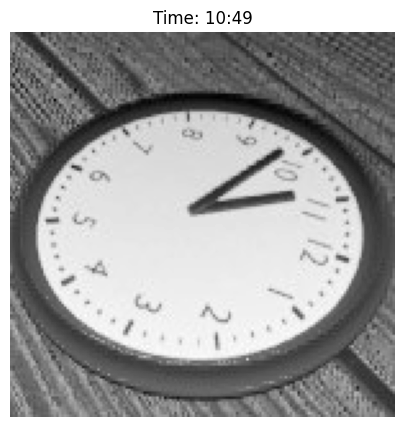

In [13]:
# Randomly select 3 images to visualize
indices = np.random.choice(images.shape[0], 3, replace=False)

for idx in indices:
    plt.figure(figsize=(5,5))
    plt.imshow(images[idx], cmap='gray')
    hour, minute = labels[idx]
    plt.title(f"Time: {hour:02}:{minute:02}")
    plt.axis("off")
    plt.show()


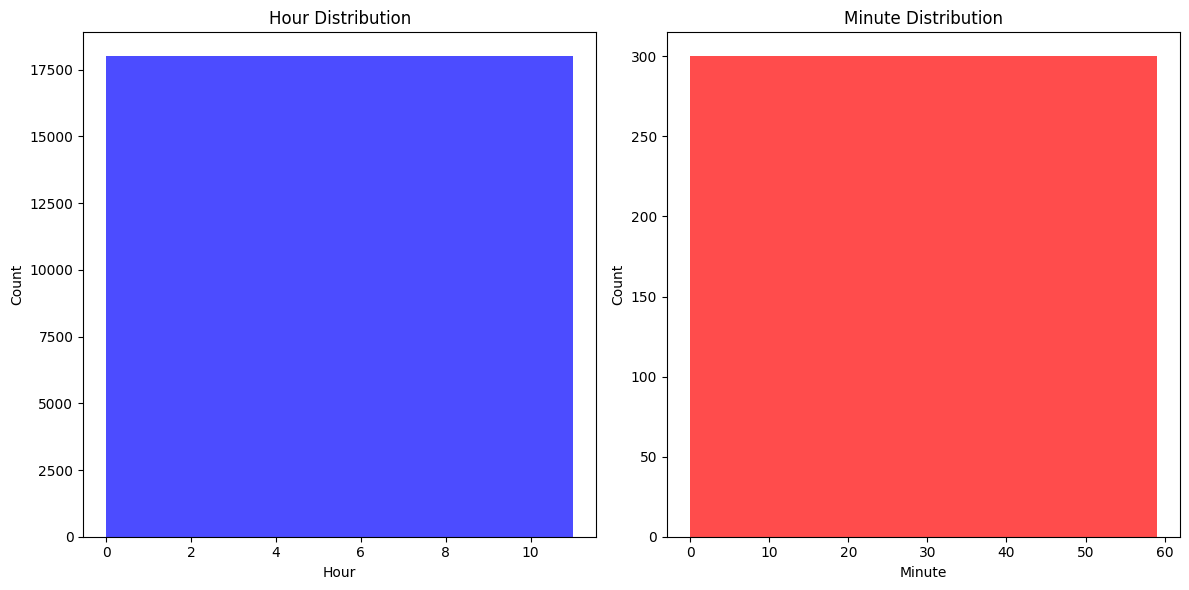

In [14]:
# Make histograms of hour / minute distribution
hours, minutes = labels[:, 0], labels[:, 1]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(hours, bins=1, color='blue', alpha=0.7)
plt.title('Hour Distribution')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(minutes, bins=60, color='red', alpha=0.7)
plt.title('Minute Distribution')
plt.xlabel('Minute')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# N-class classification model

Our first approach is to have a separate outcome for each discrete outcome. There are thus 12 * 60 = 720 different possible outcomes. However, we will restrict this at first by reducing the temporal resolution, and gradually increase the categories by using smaller time intervals.

The general structure of the model is a sequence of convolutional filters and pooling layers to process the initial image data. From there on, 7 dense layer of decreasing size are passed using ReLU activation to reach the final outcome layer.

Load tensorboard (optional)

In [ ]:
# # Load the TensorBoard plugin
# %load_ext tensorboard
# # Launches tensorboard to read the logs from ./logs directory that was specified earlier when creating the callback
# %tensorboard --logdir my_task2_logs --reload_interval 5

At first, we make a function to calculate the average time difference between predicted and actual data. This will take the shortest absolute difference, the 'common sense error'.

In [ ]:
# Function to compute average time difference
def compute_average_time_difference(y_true, y_pred):
    true_times = np.array([label_to_minutes(label) for label in y_true])
    predicted_times = np.array([label_to_minutes(label) for label in y_pred])

    absolute_differences = np.abs(true_times - predicted_times)

    # Adjusting for the 12-hour clock. If the difference is more than 360 minutes,
    # it means we have crossed the 12-hour boundary, and we should take the complementary difference.
    absolute_differences = np.where(absolute_differences > 360, 720 - absolute_differences, absolute_differences)

    return np.mean(absolute_differences)

Our first classification model has n = 12, so we only predict the hour.

In [ ]:
import tensorflow.keras as keras
from google.colab import drive
drive.mount('/content/drive')

images_path = '/content/drive/My Drive/images.npy'
labels_path = '/content/drive/My Drive/labels.npy'

images = np.load(images_path)
labels = np.load(labels_path)

# Normalize the pixel values
images = images.astype('float32') / 255.0

# Since the images are grayscale, we need to expand the dimensions so they can fit into a CNN
images = np.expand_dims(images, axis=-1)

print(f"Images shape: {images.shape}")
print(f"Images data type: {images.dtype}")
print(f"Labels shape: {labels.shape}")
print(f"Labels data type: {labels.dtype}")

# Convert hour:minute to the category label
def time_to_label(h, m):
    return h + m // 60

# Convert labels to the new categorical format
y = np.array([time_to_label(h, m) for h, m in labels])

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)

# 80% acc but overfits (19% validation acc)
model_cheap = models.Sequential([
    layers.Conv2D(activation="relu", filters=32, kernel_size=(3,3), input_shape=(150,150,1)),
    layers.Conv2D(kernel_size=(5,5), strides = (2,2), activation="relu", filters=32),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=32),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=32),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=64),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=64),


    layers.Flatten(),
    layers.Dense(units=512, activation="relu"),
    layers.Dense(units=512, activation="relu"),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=12, activation='softmax'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_cheap.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Tensorboard callback
tensorboard_cb = tf.keras.callbacks.TensorBoard('my_task2_logs/cheap_model_n=12', histogram_freq=1)

model_cheap.summary()

history12test = model_cheap.fit(X_train, y_train, epochs=40, batch_size=256, validation_split=0.2, callbacks=[tensorboard_cb])

# Recompute labels back into minutes
def label_to_minutes(label):
    return label * 60

# Predict the classes for your test set
y_pred = model_cheap.predict(X_test)
predicted_classes = np.argmax(y_pred, axis=1)

avg_difference = compute_average_time_difference(y_test, predicted_classes)
print(f"The average absolute time difference is: {avg_difference} minutes.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images shape: (18000, 150, 150, 1)
Images data type: float32
Labels shape: (18000, 2)
Labels data type: int64
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 36, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 conv2d_3 (Conv

We observe that our prediction is off by ~14 minutes on average. This is very good, and suggests that the hour was predicted correctly most of the time.

We will double the resulution by also accounting for half hours. n = 24

In [ ]:
import tensorflow.keras as keras
from google.colab import drive
drive.mount('/content/drive')

images_path = '/content/drive/My Drive/images.npy'
labels_path = '/content/drive/My Drive/labels.npy'

images = np.load(images_path)
labels = np.load(labels_path)

# Normalize the pixel values
images = images.astype('float32') / 255.0

# Since the images are grayscale, we need to expand the dimensions so they can fit into a CNN
images = np.expand_dims(images, axis=-1)

print(f"Images shape: {images.shape}")
print(f"Images data type: {images.dtype}")
print(f"Labels shape: {labels.shape}")
print(f"Labels data type: {labels.dtype}")

# Convert hour:minute to the category label
def time_to_label(h, m):
    return h * 2 + m // 30

# Convert labels to the new categorical format
y = np.array([time_to_label(h, m) for h, m in labels])

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)

# 80% acc but overfits (19% validation acc)
model_cheap = models.Sequential([
    layers.Conv2D(activation="relu", filters=32, kernel_size=(3,3), input_shape=(150,150,1)),
    layers.Conv2D(kernel_size=(5,5), strides = (2,2), activation="relu", filters=32),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=32),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=32),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=64),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=64),


    layers.Flatten(),
    layers.Dense(units=512, activation="relu"),
    layers.Dense(units=512, activation="relu"),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=24, activation='softmax'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_cheap.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Tensorboard callback
tensorboard_cb = tf.keras.callbacks.TensorBoard('my_task2_logs/cheap_model_n=12', histogram_freq=1)

model_cheap.summary()

history24test = model_cheap.fit(X_train, y_train, epochs=40, batch_size=256, validation_split=0.2, callbacks=[tensorboard_cb])

# Recompute labels back into minutes
def label_to_minutes(label):
    return label * 30

# Predict the classes for your test set
y_pred = model_cheap.predict(X_test)
predicted_classes = np.argmax(y_pred, axis=1)

avg_difference = compute_average_time_difference(y_test, predicted_classes)
print(f"The average absolute time difference is: {avg_difference} minutes.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images shape: (18000, 150, 150, 1)
Images data type: float32
Labels shape: (18000, 2)
Labels data type: int64
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 conv2d_9 (Co

We observe that accuracy and error has decreased. An explanation for this is that the model does not get enough information to predict so many different outcomes. We will notice this becoming even worse as we increase the resolution even more:

Classification model with n = 48 (so 15 minute intervals)

In [ ]:
import tensorflow.keras as keras
from google.colab import drive
drive.mount('/content/drive')

images_path = '/content/drive/My Drive/images.npy'
labels_path = '/content/drive/My Drive/labels.npy'

images = np.load(images_path)
labels = np.load(labels_path)

# Normalize the pixel values
images = images.astype('float32') / 255.0

# Since the images are grayscale, we need to expand the dimensions so they can fit into a CNN
images = np.expand_dims(images, axis=-1)

print(f"Images shape: {images.shape}")
print(f"Images data type: {images.dtype}")
print(f"Labels shape: {labels.shape}")
print(f"Labels data type: {labels.dtype}")

# Convert hour:minute to the category label
def time_to_label(h, m):
    return h * 4 + m // 15

# Convert labels to the new categorical format
y = np.array([time_to_label(h, m) for h, m in labels])

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)

# 80% acc but overfits (19% validation acc)
model_cheap = models.Sequential([
    layers.Conv2D(activation="relu", filters=32, kernel_size=(3,3), input_shape=(150,150,1)),
    layers.Conv2D(kernel_size=(5,5), strides = (2,2), activation="relu", filters=32),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=32),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=32),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=64),
    layers.Conv2D(kernel_size=(3,3), activation="relu", filters=64),


    layers.Flatten(),
    layers.Dense(units=512, activation="relu"),
    layers.Dense(units=512, activation="relu"),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=48, activation='softmax'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_cheap.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Tensorboard callback
tensorboard_cb = tf.keras.callbacks.TensorBoard('my_task2_logs/cheap_model_n=12', histogram_freq=1)

model_cheap.summary()

history48test = model_cheap.fit(X_train, y_train, epochs=40, batch_size=256, validation_split=0.2, callbacks=[tensorboard_cb])

# Recompute labels back into minutes
def label_to_minutes(label):
    return label * 15

# Predict the classes for your test set
y_pred = model_cheap.predict(X_test)
predicted_classes = np.argmax(y_pred, axis=1)

# avg_difference = compute_average_time_difference(y_test, predicted_classes)
# print(f"The average absolute time difference is: {avg_difference} minutes.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images shape: (18000, 150, 150, 1)
Images data type: float32
Labels shape: (18000, 2)
Labels data type: int64
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 36, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 conv2d_3 (Conv

NameError: ignored

In [ ]:
avg_difference = compute_average_time_difference(y_test, predicted_classes)
print(f"The average absolute time difference is: {avg_difference} minutes.")

The average absolute time difference is: 39.86666666666667 minutes.


Indeed, the problem is becoming even greater. Clearly, a fully categorical approach is not viable.
We will depict these tendencies followingly:

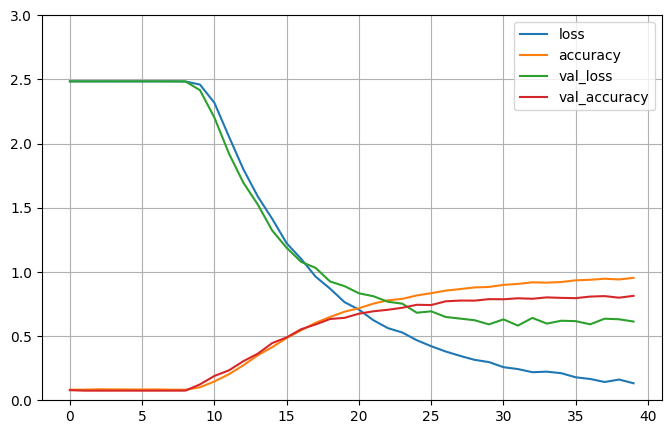

In [ ]:
# Plot learning curves of the model with 12 classes
pd.DataFrame(history12test.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3) # set the vertical range to [0-1]
plt.xlabel('Iteration')
plt.show()

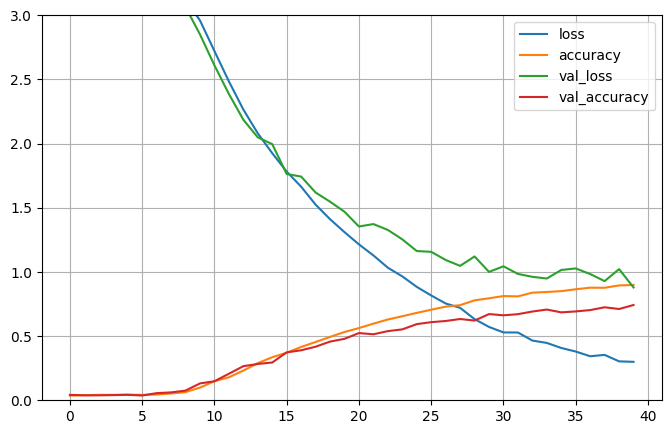

In [ ]:
# Plot learning curves of the model with 24 classes
pd.DataFrame(history24test.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3) # set the vertical range to [0-1]
plt.xlabel('Iteration')
plt.show()

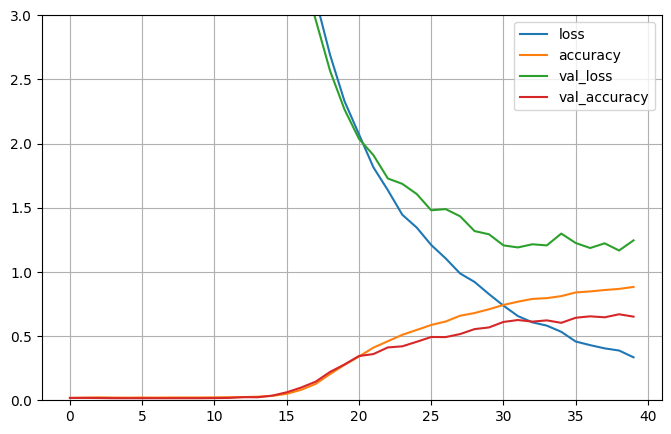

In [ ]:
# Plot learning curves of the model with 48 classes
pd.DataFrame(history48test.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3) # set the vertical range to [0-1]
plt.xlabel('Iteration')
plt.show()

Increasing the amount of classes from 12 (hours) to 24 (half hours) to 48 (15 minutes) causes decreased performance. This is visible in the descrepancy between loss and val_loss, the descrepancy between acc and val_acc, and the average absolute time difference of the predictions. Both loss-val_loss and acc-val_acc start diverging sooner for higher n and the average prediction error also increases with higher n.


**Why 720 different classes would not work:**

Insufficient Data: With more classes, we need more representative samples for each class. The dataset is limited, so the model will struggle to generalize for 720 categories.

Increased Complexity: A higher number of classes increases the model's task complexity. This can often lead to the need for a deeper or more complex model to capture patterns adequately.

Data Imbalance: With increased granularity, there's a chance that some intervals might have significantly fewer samples than others. Class imbalance can cause the model to perform poorly on underrepresented classes.

# Regression

Next, we will try the 'opposite' approach; instead of making discrete categories, we will reparameterise the labels to express time as a continuous variable ranging between 0 and 12. This will then be then modeled by a network with a regression outcome.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

images_path = '/content/drive/My Drive/images.npy'
labels_path = '/content/drive/My Drive/labels.npy'

images = np.load(images_path)
labels = np.load(labels_path)

# Normalize the pixel values
images = images.astype('float32') / 255.0

# Since the images are grayscale, we need to expand the dimensions so they can fit into a CNN
images = np.expand_dims(images, axis=-1)

print(f"Images shape: {images.shape}")
print(f"Images data type: {images.dtype}")
print(f"Labels shape: {labels.shape}")
print(f"Labels data type: {labels.dtype}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images shape: (18000, 150, 150, 1)
Images data type: float32
Labels shape: (18000, 2)
Labels data type: int64


Converting labels to be between 0 and 12 and proper decimals and normalizing them to be withind 0 and 1:

In [ ]:
# Function to normalize labels
def preprocess_labels(labels):
    new_labels = []
    for label in labels:
        hour, minute = label
        time_in_hour = hour + minute / 60.0
        new_labels.append(time_in_hour)
    # Scale the labels to [0, 1]
    max_time = 12.0
    scaled_labels = np.array(new_labels) / max_time
    return scaled_labels

new_labels = preprocess_labels(labels)

As we now have a continuous outcome, we will use a 'softplus' activation function for the final outcome of the network.

The general network structure remains the same.

In [6]:
#Split data into train test
X_train, X_test, y_train, y_test = train_test_split(images, new_labels, test_size=0.2, random_state=42)

# Create model
model_regr = models.Sequential([
    layers.Conv2D(activation='relu', filters=32, kernel_size=(3,3), strides = (2,2),input_shape=(150, 150, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=32 ,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Flatten(),

    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(1, activation='softplus')])

model_regr.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # for regression tasks

# Tensorboard callback
tensorboard_cb = tf.keras.callbacks.TensorBoard('my_task2_logs/regr_model', histogram_freq=1)

model_regr.summary()

# Train the model
history_regr = model_regr.fit(X_train, y_train, epochs=40, batch_size=512, validation_split=0.2, callbacks=[tensorboard_cb])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 74, 74, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 37, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        1

To calculate the time difference between predicted and actual values, we need to use a slightly different method to account for the new format of the outcome variable. We will calculate the absolute difference between prediction and true value in both directions and then choose the minimum.

In [7]:
def difference_func(pred, y):
    # Transpose the predicted values for array compatibility
    pred = np.transpose(pred)

    # Calculate the absolute difference between the predicted and true values
    diff_one = np.maximum(pred, y) - np.minimum(pred, y)

    # Calculate the 'cyclic' difference, considering the circular nature of a clock.
    # For instance, the difference between 11:55 and 12:05 should be 10 minutes,
    # not 110 minutes if we were to calculate it linearly.
    diff_two = np.minimum(pred, y) + 1 - np.maximum(pred, y)

    # For each prediction, take the smaller difference, whether it's the direct
    # difference or the cyclic one.
    return np.minimum(diff_one, diff_two)

# Make predictions on the test set
y_pred = model_regr.predict(X_test)

# Compute the differences between the true and predicted values using the custom function
result = difference_func(y_pred, y_test)

# Convert the mean absolute difference to minutes. Since the values were initially normalized to [0,1]
# to represent the hours on a clock, multiplying by 60 gives the difference in minutes.
# Multiplying by 12 adjusts for the 12-hour nature of an analogue clock.
mean_absolute_difference_minutes = np.mean(result) * 60 * 12

print(f"The mean absolute difference in time is: {mean_absolute_difference_minutes:.2f} minutes.")



113/113 [==============================] - 2s 13ms/step
The mean absolute difference in time is: 25.19 minutes.


We notice that this model performs better than the high resolution categorical models, but still fairly bad.

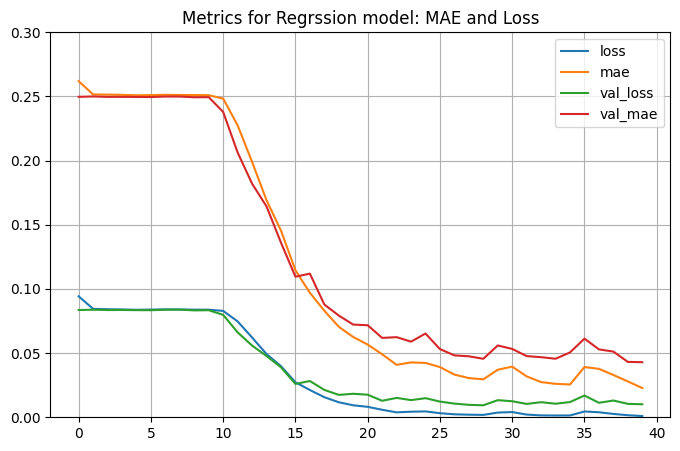

In [12]:
# Plot learning curves of the model with 48 classes
pd.DataFrame(history_regr.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.3)
plt.title('Metrics for Regression model: MAE and Loss')
plt.xlabel('Iteration')
plt.show()

Performance becomes stagnant after ~25 epochs.

# Multi-head model

Finally, we will make a model which uses a mixture of both approaches.

The basis of the model is the same sequence of convolutional filters and pooling layers. From there on, a dense layer of size 256x256 is passed to two separate structures in parallel:

For the hours, we will use a categorical prediction using 12 softmax activation functions.

For the minutes, we will use a continuous outcome using softplus.

These branches simply consist of multiple dense layers.

In [ ]:
import tensorflow.keras as keras
from google.colab import drive
drive.mount('/content/drive')

images_path = '/content/drive/My Drive/images.npy'
labels_path = '/content/drive/My Drive/labels.npy'

images = np.load(images_path)
labels = np.load(labels_path)

# Normalize the pixel values
images = images.astype('float32') / 255.0

# Since the images are grayscale, we need to expand the dimensions so they can fit into a CNN
images = np.expand_dims(images, axis=-1)

print(f"Images shape: {images.shape}")
print(f"Images data type: {images.dtype}")
print(f"Labels shape: {labels.shape}")
print(f"Labels data type: {labels.dtype}")


# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

y_train_hours = y_train[:,0]
y_train_minutes = y_train[:,1] / 60.0
y_test_hours = y_test[:,0]
y_test_minutes = y_test[:,1] / 60.0


# Main trunk of the model
base_model = models.Sequential([
    layers.Input(shape=(150,150,1)),
    layers.Conv2D(32, kernel_size=(5,5), strides=(2,2), activation="relu"),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(32, kernel_size=(3,3), activation="relu"),
    layers.Conv2D(32, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.Conv2D(64, kernel_size=(1,1), activation="relu"),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(256, activation="relu")
])

# Branch for hour
hour = layers.Dense(256,activation = "relu")(base_model.output)
hour = layers.Dense(128,activation = "relu")(hour)
hour = layers.Dense(64,activation = "relu")(hour)
hour = layers.Dense(32,activation = "relu")(hour)
hour = layers.Dense(16,activation = "relu")(hour)
hour = layers.Dense(12, activation= "softmax", name= "hour")(hour)

# Branch for minute
minute = layers.Dense(256, activation = "relu")(base_model.output)
minute = layers.Dense(256, activation = "relu")(minute)
minute = layers.Dense(256, activation = "relu")(minute)
minute = layers.Dense(128, activation = "relu")(minute)
minute = layers.Dense(64, activation = "relu")(minute)
minute = layers.Dense(32, activation = "relu")(minute)
minute = layers.Dense(16, activation = "relu")(minute)
minute = layers.Dense(1, activation = "softplus", name = "minute")(minute)

# Combined model
final_model = tf.keras.models.Model(inputs=base_model.input, outputs=[hour, minute])

optimizer = keras.optimizers.Adam()
final_model.compile(optimizer=optimizer, loss=['sparse_categorical_crossentropy', 'mse'], metrics=['accuracy', 'mae'])

final_model.summary()

history_multihead = final_model.fit(X_train, [y_train_hours, y_train_minutes], epochs=30, batch_size=256, validation_split=0.2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images shape: (18000, 150, 150, 1)
Images data type: float32
Labels shape: (18000, 2)
Labels data type: int64
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 1)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 73, 73, 32)           832       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 36, 36, 32)           0         ['conv2d_6[0][0]']            
 g2D)                                                

In [ ]:
# Predictions
predictions = final_model.predict(X_test)

hour_p = np.argmax(predictions[0], axis = 1)
minutes_p = predictions[1]

def difference_func(h_pred,m_pred,y_h,y_m):
  tmp = h_pred * 60 + np.transpose(m_pred )# in minute
  tmp2 = y_h * 60 + y_m
  diff_one = np.maximum(tmp,tmp2) - np.minimum(tmp,tmp2)
  diff_two = np.minimum(tmp,tmp2) + 720 - np.maximum(tmp,tmp2)
  return np.minimum(diff_one,diff_two)

error = difference_func(hour_p,minutes_p,y_test_hours,y_test_minutes)

print(f"The average absolute time difference is: {np.mean(error)} minutes.")

113/113 [==============================] - 0s 4ms/step
The average absolute time difference is: 8.0604964673733 minutes.


We can see that accuracy has been improved, and the average absolute time difference is the lowest out of all of our models.

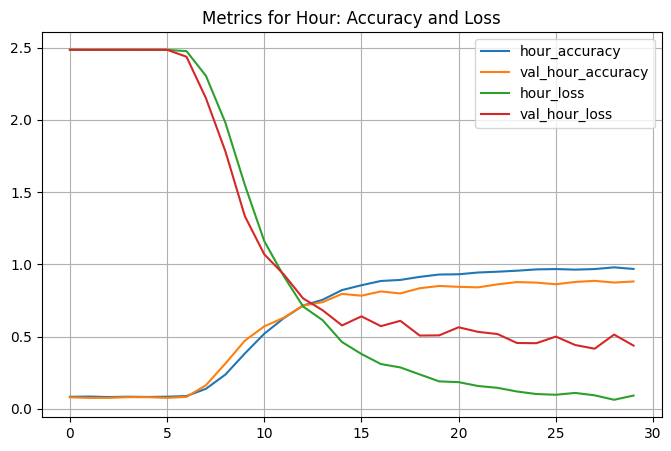

In [ ]:
# Extract the history data into a dataframe
history_df = pd.DataFrame(history_multihead.history)

# Select only the metrics of interest
metrics_to_plot = ['hour_accuracy', 'val_hour_accuracy', 'hour_loss', 'val_hour_loss']
history_subset = history_df[metrics_to_plot]

# Plot the selected metrics
history_subset.plot(figsize=(8, 5))
plt.grid(True)
plt.title('Metrics for Hour: Accuracy and Loss')
plt.xlabel('Iteration')
plt.show()

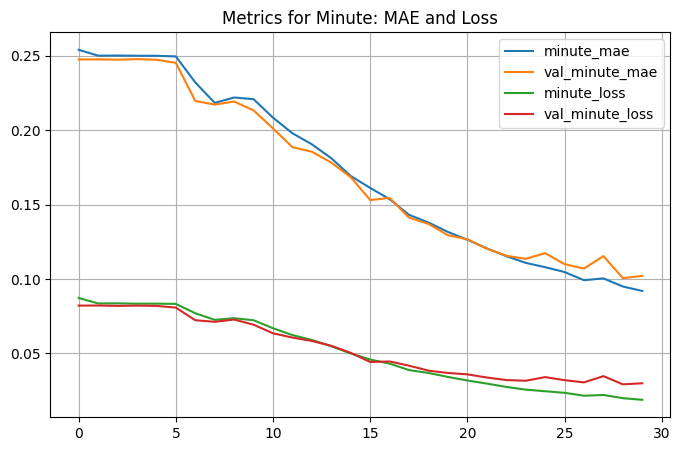

In [ ]:
# Extract the history data into a dataframe
history_df = pd.DataFrame(history_multihead.history)

# Select only the metrics of interest
metrics_to_plot = ['minute_mae', 'val_minute_mae', 'minute_loss', 'val_minute_loss']
history_subset = history_df[metrics_to_plot]

# Plot the selected metrics
history_subset.plot(figsize=(8, 5))
plt.grid(True)
plt.title('Metrics for Minute: MAE and Loss')
plt.xlabel('Iteration')
plt.show()

### Conclusions for multi-head model

The multihead model performs better than the classification or regression models in isolation because it is able to benefit from the strengths of both models by combining them. For a parameter with a smaller discrete support (hours), it is reasonable to use a categorical classifier. For a more detailed metric (minutes), it is easier to use regression to get an estimate.

We observe that the classification part starts to overfit around the same val_accuracy score as the hourly classification model in isolation did. But because the predicions also take the regression part for the minutes into account, it can use the low MAE (which we also found in the isolated regression model) to dial in on the minutes part.

Splitting the task into two subtastks allows us to maximise accuracy on the prediction of the hour value while also minimising MAE for the prediction of the minute value.